## 전처리

In [ ]:
import os
import numpy as np
import pydicom
import SimpleITK as sitk
import cv2
import pandas as pd
from tqdm import tqdm
import re
from sklearn.model_selection import KFold

# ==========================================
# [설정] 경로 및 파라미터 완벽 세팅
# ==========================================
# 전체 프로젝트 기본 경로
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection'

# 1. 뼈 원본 사진 (DICOM) 경로 (사용자님 요청 경로!)
DICOM_ROOT_DIRS = [
    os.path.join(BASE_DIR, 'old_train', 'train_images')
]

# 2. 뼈 위치를 잡아줄 마스크 경로 (이전에 뽑아두신 2019명용 마스크 폴더)
MASK_DIR = os.path.join(BASE_DIR, 'old_train', 'pseudo_segmentation_masks_2019') 

# 3. 235명 골든 명단 및 진짜 정답 박스
BBOX_CSV_PATH = os.path.join(BASE_DIR, 'golden_dataset', 'filtered_train_bounding_boxes.csv')

# 4. 새롭게 예쁘게 잘라서 저장할 폴더 (이름을 명확하게 지정)
OUTPUT_DIR = os.path.join(BASE_DIR, 'golden_dataset', 'detection_cropped_235_3ch_new') 

# [출력] 매니페스트 (이전과 겹치지 않게 이름 살짝 변경)
OUTPUT_MANIFEST_FULL = os.path.join(BASE_DIR, 'golden_dataset', 'det_train_manifest_235_full_new.csv')
OUTPUT_MANIFEST_BALANCED = os.path.join(BASE_DIR, 'golden_dataset', 'det_train_manifest_235_balanced_new.csv')

WL, WW = 500, 2000
TARGET_SIZE = 512
MARGIN_RATIO = 0.2 

# ==========================================
# [함수] 유틸리티
# ==========================================
def apply_windowing(img, wl, ww):
    img_min, img_max = wl - ww // 2, wl + ww // 2
    img = np.clip(img, img_min, img_max)
    return ((img - img_min) / ww).astype(np.float32)

def get_mask_bbox(mask_slice):
    rows = np.any(mask_slice > 0, axis=1)
    cols = np.any(mask_slice > 0, axis=0)
    if not np.any(rows) or not np.any(cols): return None
    y_min, y_max = np.where(rows)[0][[0, -1]]
    x_min, x_max = np.where(cols)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def make_square_box(x1, y1, x2, y2, img_w, img_h, margin=0.2):
    w = x2 - x1
    h = y2 - y1
    cx, cy = x1 + w // 2, y1 + h // 2
    max_side = max(w, h)
    new_size = int(max_side * (1 + margin))
    half_size = new_size // 2
    new_x1 = max(0, cx - half_size)
    new_y1 = max(0, cy - half_size)
    new_x2 = min(img_w, cx + half_size)
    new_y2 = min(img_h, cy + half_size)
    if new_x2 <= new_x1 or new_y2 <= new_y1: return 0, 0, img_w, img_h
    return int(new_x1), int(new_y1), int(new_x2), int(new_y2)

def get_slice_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# ==========================================
# [메인] Safe Crop & Balance
# ==========================================
def process_safe_crop_and_balance():
    if not os.path.exists(BBOX_CSV_PATH):
        print(f"❌ 라벨 파일이 없습니다: {BBOX_CSV_PATH}")
        return
    
    bbox_df = pd.read_csv(BBOX_CSV_PATH)
    
    # 🎯 [핵심] 235명 명단을 마스크 폴더가 아니라 '정답지(bbox_df)'에서 직접 추출!
    uids_to_process = sorted(list(bbox_df['StudyInstanceUID'].astype(str).unique()))
    print(f"📖 타겟 환자 수: {len(uids_to_process)}명 (Golden 235명)")

    new_rows = []
    
    print(f"🚀 [Safe Crop] 235명 정예 데이터 전처리 시작")
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # --- 1. 전처리 루프 (Safe Crop) ---
    for uid in tqdm(uids_to_process):
        dicom_dir = None
        for root in DICOM_ROOT_DIRS:
            temp_path = os.path.join(root, uid)
            if os.path.exists(temp_path):
                dicom_dir = temp_path
                break
                
        if dicom_dir is None: 
            print(f"⚠️ DICOM을 찾을 수 없음: {uid}")
            continue 

        try:
            # 메타데이터 로드
            dcm_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
            dcm_meta = []
            for f in dcm_files:
                slice_num = get_slice_number(f)
                ds = pydicom.dcmread(os.path.join(dicom_dir, f), stop_before_pixels=True)
                dcm_meta.append({
                    'filename': f, 'full_path': os.path.join(dicom_dir, f),
                    'slice_number': slice_num, 
                    'z_pos': float(ds.ImagePositionPatient[2]),
                    'slope': float(getattr(ds, 'RescaleSlope', 1.0)),
                    'intercept': float(getattr(ds, 'RescaleIntercept', 0.0))
                })
            dcm_meta.sort(key=lambda x: x['z_pos'], reverse=True)
            
            # 볼륨 & 마스크 로드
            full_vol = []
            for m in dcm_meta:
                ds = pydicom.dcmread(m['full_path'])
                px = ds.pixel_array.astype(np.float32) * m['slope'] + m['intercept']
                full_vol.append(apply_windowing(px, WL, WW))
            full_vol = np.stack(full_vol, axis=0)
            
            mask_path = os.path.join(MASK_DIR, f"{uid}_mask.nii.gz")
            if not os.path.exists(mask_path):
                print(f"⚠️ 마스크를 찾을 수 없음: {uid}")
                continue
                
            mask_itk = sitk.ReadImage(mask_path)
            mask_vol = sitk.GetArrayFromImage(mask_itk).astype(np.uint8)
            mask_vol = np.flip(mask_vol, axis=(0, 1))

            pat_bbox_df = bbox_df[bbox_df['StudyInstanceUID'] == uid]

            # 슬라이스 처리
            patient_save_dir = os.path.join(OUTPUT_DIR, uid)
            os.makedirs(patient_save_dir, exist_ok=True)
            
            for z_idx, meta in enumerate(dcm_meta):
                current_slice_num = meta['slice_number']
                if z_idx >= len(mask_vol): break
                m_slice = mask_vol[z_idx]
                
                # 마스크 박스
                mask_bbox = get_mask_bbox(m_slice)
                if mask_bbox is None: continue
                mx1, my1, mx2, my2 = mask_bbox
                
                # Safe Crop Logic: 정답 박스 포함하여 영역 확장
                relevant_boxes = pat_bbox_df[pat_bbox_df['slice_number'] == current_slice_num]
                
                final_x1, final_y1, final_x2, final_y2 = mx1, my1, mx2, my2
                
                if len(relevant_boxes) > 0:
                    for _, row in relevant_boxes.iterrows():
                        bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                        bx2, by2 = bx + bw, by + bh
                        final_x1 = min(final_x1, bx)
                        final_y1 = min(final_y1, by)
                        final_x2 = max(final_x2, bx2)
                        final_y2 = max(final_y2, by2)
                
                ori_h, ori_w = m_slice.shape
                cx1, cy1, cx2, cy2 = make_square_box(final_x1, final_y1, final_x2, final_y2, ori_w, ori_h, MARGIN_RATIO)
                crop_w, crop_h = cx2 - cx1, cy2 - cy1
                if crop_w == 0: continue
                
                # 이미지 크롭 (3채널 - 2.5D)
                z_prev = max(0, z_idx - 1)
                z_next = min(len(full_vol) - 1, z_idx + 1)
                img_3ch = np.stack([full_vol[z_prev], full_vol[z_idx], full_vol[z_next]], axis=0) 
                
                cropped_3ch = img_3ch[:, cy1:cy2, cx1:cx2]
                cropped_hwc = np.transpose(cropped_3ch, (1, 2, 0))
                resized_hwc = cv2.resize(cropped_hwc, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_LINEAR)
                final_data = np.transpose(resized_hwc, (2, 0, 1)) 
                
                # BBox 변환
                is_fracture = 0
                new_bboxes = []
                
                if len(relevant_boxes) > 0:
                    is_fracture = 1
                    scale_x = TARGET_SIZE / crop_w
                    scale_y = TARGET_SIZE / crop_h
                    for _, row in relevant_boxes.iterrows():
                        bx, by, bw, bh = row['x'], row['y'], row['width'], row['height']
                        new_x = (bx - cx1) * scale_x
                        new_y = (by - cy1) * scale_y
                        new_w = bw * scale_x
                        new_h = bh * scale_y
                        
                        norm_x = new_x / TARGET_SIZE
                        norm_y = new_y / TARGET_SIZE
                        norm_w = new_w / TARGET_SIZE
                        norm_h = new_h / TARGET_SIZE
                        
                        if (norm_x + norm_w > 0) and (norm_y + norm_h > 0) and (norm_x < 1) and (norm_y < 1):
                            new_bboxes.append([norm_x, norm_y, norm_w, norm_h])
                
                # 저장
                file_name = f"{z_idx:04d}.npz" 
                save_path = os.path.join(patient_save_dir, file_name)
                np.savez_compressed(save_path, data=final_data)
                
                # 📝 저장할 때 'file_path'를 새 폴더 이름으로 맞춰줍니다!
                new_rows.append({
                    'StudyInstanceUID': uid, 'slice_idx': z_idx,
                    'original_slice_number': current_slice_num,
                    'file_path': os.path.join('detection_cropped_235_3ch_new', uid, file_name),
                    'fracture': is_fracture,
                    'bbox': str(new_bboxes),
                    'ver_level': 0
                })
                
        except Exception as e:
            print(f"❌ Error {uid}: {e}")
            continue

    # --- 2. 1:1 밸런싱 로직 ---
    full_df = pd.DataFrame(new_rows)
    print(f"\n📊 전체 데이터 생성 완료: {len(full_df)}개")
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    full_df['fold'] = -1
    unique_uids = full_df['StudyInstanceUID'].unique()
    for f_idx, (_, val_idx) in enumerate(kf.split(unique_uids), 1):
        full_df.loc[full_df['StudyInstanceUID'].isin(unique_uids[val_idx]), 'fold'] = f_idx
    
    full_df.to_csv(OUTPUT_MANIFEST_FULL, index=False)
    print(f"📁 전체 매니페스트 저장됨: {OUTPUT_MANIFEST_FULL}")

    print("⚖️ 1:1 균형 맞추기 시작...")
    pos_df = full_df[full_df['fracture'] == 1].reset_index(drop=True)
    neg_df = full_df[full_df['fracture'] == 0].reset_index(drop=True)
    
    pos_count = len(pos_df)
    neg_count = len(neg_df)
    
    print(f"   - Fracture: {pos_count}")
    print(f"   - Normal: {neg_count}")
    
    if neg_count > pos_count:
        neg_sampled = neg_df.sample(n=pos_count, random_state=42).reset_index(drop=True)
    else:
        neg_sampled = neg_df 
        
    balanced_df = pd.concat([pos_df, neg_sampled], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)
    balanced_df.to_csv(OUTPUT_MANIFEST_BALANCED, index=False)
    
    print(f"\n✅ [Complete] 1:1 학습용 데이터셋 준비 완료!")
    print(f"   - 총 데이터: {len(balanced_df)} (골절 {pos_count} : 정상 {len(neg_sampled)})")

if __name__ == '__main__':
    process_safe_crop_and_balance()

## 학습

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import cv2
import timm  
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GroupShuffleSplit
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt 

# --- [1. 시스템 에러 및 멈춤 방지] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
cv2.setNumThreads(0) 
torch.backends.cudnn.benchmark = True # ⚡ 고속 학습 치트키 1

# ==========================================
# 2. 설정 (Configuration)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection',
    
    # 🌟 2019명 3채널 매니페스트 (여기서 파일 경로를 읽어옵니다)
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\old_train\det_train_manifest_2019_3ch.csv',
    
    # 🛡️ 235명 명단 추출용 CSV
    'golden_bbox_csv': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\filtered_train_bounding_boxes.csv',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k', 
    'img_size': 512,    
    'batch_size': 16,      # ⚡ AMP 적용으로 메모리가 널널해지므로 32로 상향!
    'epochs': 100,          # 235명 정예학습이므로 50에폭이면 충분합니다.
    'patience': 10,       
    'learning_rate': 5e-5, 
    'weight_decay': 5e-2,  
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'save_dir': './runs/rsna_clf_efficientnet_golden_235' # 📁 새 폴더에 깔끔하게 저장
}

# ==========================================
# 3. 데이터 증강 (Albumentations)
# ==========================================
train_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.HorizontalFlip(p=0.5), 
    A.Affine(scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), rotate=(-10, 10), p=0.5), # ShiftScaleRotate 최신화
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5), 
    A.GaussNoise(p=0.3),                                                                 # var_limit 제거
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3), 
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# ==========================================
# 4. 데이터셋
# ==========================================
class RSNAClfDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 📂 2019명 3채널 폴더(old_train)에서 이미지 로드!
        full_path = os.path.join(self.base_dir, 'old_train', row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        img_uint8 = (img * 255).astype(np.uint8)
        channels = [self.clahe.apply(img_uint8[i]) for i in range(3)]
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms:
            img_tensor = self.transforms(image=img_hwc)['image']
        else:
            img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = torch.tensor([float(row['fracture'])], dtype=torch.float32)
        return img_tensor, label

# ==========================================
# 5. 모델 구성
# ==========================================
def build_model(model_name, pretrained=True):
    model = timm.create_model(
        model_name, 
        pretrained=pretrained, 
        in_chans=3, 
        num_classes=1,
        drop_rate=0.3,       
        drop_path_rate=0.2   
    )
    return model

# ==========================================
# 6. 학습 및 검증 함수 (⚡ AMP 고속 훈련 적용)
# ==========================================
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # ⚡ Mixed Precision (속도 2배 향상, 메모리 절반)
        with torch.amp.autocast('cuda'): 
            outputs = model(images)  
            loss = criterion(outputs, labels) 
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})
        
    return running_loss / len(dataloader)

@torch.no_grad()
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    pbar = tqdm(dataloader, desc="Validating", leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        probs = torch.sigmoid(outputs).cpu().numpy()
        targets = labels.cpu().numpy()
        
        all_preds.extend(probs)
        all_targets.extend(targets)
        
    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets).flatten()
    preds_binary = (all_preds >= 0.5).astype(int)
    val_loss = running_loss / len(dataloader)
    
    try: auc = roc_auc_score(all_targets, all_preds)
    except: auc = 0.5 
    acc = accuracy_score(all_targets, preds_binary)
    recall = recall_score(all_targets, preds_binary, zero_division=0)
    precision = precision_score(all_targets, preds_binary, zero_division=0) 
    f1 = f1_score(all_targets, preds_binary, zero_division=0)              
    
    return val_loss, auc, acc, recall, precision, f1

# ==========================================
# 7. 메인 실행
# ==========================================
if __name__ == '__main__':
    os.makedirs(CONFIG['save_dir'], exist_ok=True)
    device = CONFIG['device']
    
    print("📖 데이터 로드 및 '진짜 정답지' 결합 중...")
    
    # 1. 3채널 파일 경로가 있는 CSV (가짜 정답지가 들어있음 ❌)
    df_3ch = pd.read_csv(CONFIG['manifest_path']) 
    
    # 2. 의사가 친 BBox 기반의 진짜 정답지가 있는 CSV (사용자님이 업로드하신 파일 ⭕)
    # (경로는 사용자님 PC 환경에 맞게 적어주세요!)
    TRUE_LABEL_CSV = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_full.csv'
    df_true = pd.read_csv(TRUE_LABEL_CSV)
    
    df_3ch['StudyInstanceUID'] = df_3ch['StudyInstanceUID'].astype(str)
    df_true['StudyInstanceUID'] = df_true['StudyInstanceUID'].astype(str)
    
    # 3. [핵심] 3채널 CSV에서는 '경로'만, 진짜 CSV에서는 '정답'만 가져와서 결합!
    df_merged = pd.merge(
        df_3ch[['StudyInstanceUID', 'original_slice_number', 'file_path']], # 3채널 이미지 경로
        df_true[['StudyInstanceUID', 'original_slice_number', 'fracture']], # 진짜 100% 정답
        on=['StudyInstanceUID', 'original_slice_number'], 
        how='inner'
    )
    
    print(f"✅ 진짜 정답지 결합 완료! (총 {len(df_merged):,}장 획득)")

    # 4. 이제 이 df_merged가 우리의 완벽한 235명 정예 데이터가 됩니다!
    df_235 = df_merged.reset_index(drop=True)

    # 🎯 환자 기준으로 Train(80%) / Val(20%) 분할
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    train_idx, val_idx = next(gss.split(df_235, groups=df_235['StudyInstanceUID']))
    
    train_df = df_235.iloc[train_idx].reset_index(drop=True)
    val_df = df_235.iloc[val_idx].reset_index(drop=True)
    
    # 🎯 [핵심] Train 셋만 골절(1)과 정상(0)을 1:1로 맞춤 (다이어트)
    train_frac = train_df[train_df['fracture'] == 1]
    train_norm = train_df[train_df['fracture'] == 0].sample(n=len(train_frac), random_state=42)
    train_df_balanced = pd.concat([train_frac, train_norm]).sample(frac=1).reset_index(drop=True)
    
    print("\n" + "="*40)
    print("⚖️ [데이터 분할 완료]")
    print(f"  - Train (1:1 밸런스 강제) : {len(train_df_balanced):,}장 (골절 {len(train_frac)} / 정상 {len(train_norm)})")
    print(f"  - Val (전체 슬라이스 유지): {len(val_df):,}장 (골절 {len(val_df[val_df['fracture']==1])} / 정상 {len(val_df[val_df['fracture']==0])})")
    print("="*40)
    
    # ⚡ num_workers=4 로 데이터 로딩 속도 극대화!
    train_ds = RSNAClfDataset(train_df_balanced, CONFIG['base_dir'], transforms=train_transforms)
    val_ds = RSNAClfDataset(val_df, CONFIG['base_dir'], transforms=val_transforms)
    
    train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0, pin_memory=True)
    
    model = build_model(CONFIG['model_name']).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])
    scaler = torch.amp.GradScaler('cuda') # ⚡ AMP 스케일러 생성
    
    best_auc = 0.0
    early_stop_counter = 0 
    
    history = {
        'epoch': [], 'train_loss': [], 'val_loss': [], 
        'val_auc': [], 'val_acc': [], 'val_recall': [],
        'val_precision': [], 'val_f1': []
    }
    
    print(f"\n🚀 [Golden 235 Mode] 정예 훈련 시작! (Model: {CONFIG['model_name']})")
    
    for epoch in range(1, CONFIG['epochs'] + 1):
        print(f"\n[Epoch {epoch}/{CONFIG['epochs']}]")
        
        # ⚡ 훈련 함수에 scaler 전달
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
        val_loss, val_auc, val_acc, val_recall, val_precision, val_f1 = validate(model, val_loader, criterion, device)
        
        scheduler.step() 
        
        print(f"📉 Train Loss: {train_loss:.4f} | 📈 Val Loss: {val_loss:.4f}")
        print(f"🏆 AUC: {val_auc:.4f} | Acc: {val_acc:.4f} | 🔥 Recall: {val_recall:.4f} | 🎯 Prec: {val_precision:.4f} | ⚖️ F1: {val_f1:.4f}")
        
        # 📝 기록 저장
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        history['val_acc'].append(val_acc)
        history['val_recall'].append(val_recall)
        history['val_precision'].append(val_precision)
        history['val_f1'].append(val_f1)
        
        # 💾 [핵심] 매 에폭마다 엑셀(CSV) 즉시 덮어쓰기 (자동 저장)
        history_df = pd.DataFrame(history)
        csv_path = os.path.join(CONFIG['save_dir'], "history_golden_235.csv")
        history_df.to_csv(csv_path, index=False)
        
        if val_auc > best_auc:
            best_auc = val_auc
            early_stop_counter = 0 
            save_path = os.path.join(CONFIG['save_dir'], "best_efficientnet_golden_235.pth")
            torch.save(model.state_dict(), save_path)
            print(f"💾 Best Model 저장됨! (AUC: {best_auc:.4f}) - 엑셀 자동저장 완료 🔄")
        else:
            early_stop_counter += 1 
            print(f"⚠️ 기록 갱신 실패... (Early Stopping 카운터: {early_stop_counter}/{CONFIG['patience']})")
            
            if early_stop_counter >= CONFIG['patience']:
                print(f"\n🚨 {CONFIG['patience']} 에폭 동안 성능 향상이 없어 학습을 조기 종료(Early Stopping) 합니다!")
                break 
                
    print(f"\n✨ 정예 훈련 완료! 최고 AUC: {best_auc:.4f}")

C:\Users\smc\AppData\Local\Temp\ipykernel_22868\2307021792.py:54: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.3),


📖 데이터 로드 및 '진짜 정답지' 결합 중...
✅ 진짜 정답지 결합 완료! (총 43,928장 획득)

⚖️ [데이터 분할 완료]
  - Train (1:1 밸런스 강제) : 10,582장 (골절 5291 / 정상 5291)
  - Val (전체 슬라이스 유지): 8,882장 (골절 1231 / 정상 7651)



🚀 [Golden 235 Mode] 정예 훈련 시작! (Model: tf_efficientnetv2_s.in21k_ft_in1k)

[Epoch 1/100]


📉 Train Loss: 1.5388 | 📈 Val Loss: 0.6103
🏆 AUC: 0.5946 | Acc: 0.6804 | 🔥 Recall: 0.3550 | 🎯 Prec: 0.1761 | ⚖️ F1: 0.2354
💾 Best Model 저장됨! (AUC: 0.5946) - 엑셀 자동저장 완료 🔄

[Epoch 2/100]


📉 Train Loss: 0.9722 | 📈 Val Loss: 0.7852
🏆 AUC: 0.5760 | Acc: 0.5942 | 🔥 Recall: 0.5077 | 🎯 Prec: 0.1725 | ⚖️ F1: 0.2575
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 1/10)

[Epoch 3/100]


📉 Train Loss: 0.8770 | 📈 Val Loss: 0.4559
🏆 AUC: 0.6368 | Acc: 0.8145 | 🔥 Recall: 0.1722 | 🎯 Prec: 0.2521 | ⚖️ F1: 0.2046
💾 Best Model 저장됨! (AUC: 0.6368) - 엑셀 자동저장 완료 🔄

[Epoch 4/100]


📉 Train Loss: 0.7484 | 📈 Val Loss: 0.6535
🏆 AUC: 0.6666 | Acc: 0.6877 | 🔥 Recall: 0.5150 | 🎯 Prec: 0.2255 | ⚖️ F1: 0.3137
💾 Best Model 저장됨! (AUC: 0.6666) - 엑셀 자동저장 완료 🔄

[Epoch 5/100]


📉 Train Loss: 0.6505 | 📈 Val Loss: 0.5492
🏆 AUC: 0.6948 | Acc: 0.7702 | 🔥 Recall: 0.4379 | 🎯 Prec: 0.2855 | ⚖️ F1: 0.3456
💾 Best Model 저장됨! (AUC: 0.6948) - 엑셀 자동저장 완료 🔄

[Epoch 6/100]


📉 Train Loss: 0.5540 | 📈 Val Loss: 0.6826
🏆 AUC: 0.6932 | Acc: 0.6817 | 🔥 Recall: 0.5711 | 🎯 Prec: 0.2342 | ⚖️ F1: 0.3322
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 1/10)

[Epoch 7/100]


📉 Train Loss: 0.4837 | 📈 Val Loss: 0.6771
🏆 AUC: 0.6980 | Acc: 0.7318 | 🔥 Recall: 0.5028 | 🎯 Prec: 0.2591 | ⚖️ F1: 0.3420
💾 Best Model 저장됨! (AUC: 0.6980) - 엑셀 자동저장 완료 🔄

[Epoch 8/100]


📉 Train Loss: 0.4130 | 📈 Val Loss: 0.6774
🏆 AUC: 0.7227 | Acc: 0.7381 | 🔥 Recall: 0.5183 | 🎯 Prec: 0.2691 | ⚖️ F1: 0.3542
💾 Best Model 저장됨! (AUC: 0.7227) - 엑셀 자동저장 완료 🔄

[Epoch 9/100]


📉 Train Loss: 0.3564 | 📈 Val Loss: 0.6093
🏆 AUC: 0.7103 | Acc: 0.7896 | 🔥 Recall: 0.4070 | 🎯 Prec: 0.3055 | ⚖️ F1: 0.3490
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 1/10)

[Epoch 10/100]


📉 Train Loss: 0.3047 | 📈 Val Loss: 0.6745
🏆 AUC: 0.7157 | Acc: 0.8017 | 🔥 Recall: 0.4549 | 🎯 Prec: 0.3394 | ⚖️ F1: 0.3888
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 2/10)

[Epoch 11/100]


📉 Train Loss: 0.2652 | 📈 Val Loss: 0.7876
🏆 AUC: 0.7064 | Acc: 0.7875 | 🔥 Recall: 0.4208 | 🎯 Prec: 0.3061 | ⚖️ F1: 0.3544
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 3/10)

[Epoch 12/100]


📉 Train Loss: 0.2314 | 📈 Val Loss: 0.7276
🏆 AUC: 0.7443 | Acc: 0.8035 | 🔥 Recall: 0.4647 | 🎯 Prec: 0.3450 | ⚖️ F1: 0.3960
💾 Best Model 저장됨! (AUC: 0.7443) - 엑셀 자동저장 완료 🔄

[Epoch 13/100]


📉 Train Loss: 0.2149 | 📈 Val Loss: 0.7546
🏆 AUC: 0.7250 | Acc: 0.8245 | 🔥 Recall: 0.3712 | 🎯 Prec: 0.3680 | ⚖️ F1: 0.3696
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 1/10)

[Epoch 14/100]


📉 Train Loss: 0.1949 | 📈 Val Loss: 0.8107
🏆 AUC: 0.7084 | Acc: 0.8204 | 🔥 Recall: 0.3444 | 🎯 Prec: 0.3498 | ⚖️ F1: 0.3471
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 2/10)

[Epoch 15/100]


📉 Train Loss: 0.1737 | 📈 Val Loss: 0.8577
🏆 AUC: 0.7198 | Acc: 0.7776 | 🔥 Recall: 0.4817 | 🎯 Prec: 0.3073 | ⚖️ F1: 0.3752
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 3/10)

[Epoch 16/100]


📉 Train Loss: 0.1630 | 📈 Val Loss: 0.7862
🏆 AUC: 0.7313 | Acc: 0.7995 | 🔥 Recall: 0.4598 | 🎯 Prec: 0.3365 | ⚖️ F1: 0.3886
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 4/10)

[Epoch 17/100]


📉 Train Loss: 0.1433 | 📈 Val Loss: 0.8253
🏆 AUC: 0.7146 | Acc: 0.8172 | 🔥 Recall: 0.3907 | 🎯 Prec: 0.3550 | ⚖️ F1: 0.3720
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 5/10)

[Epoch 18/100]


📉 Train Loss: 0.1297 | 📈 Val Loss: 0.8087
🏆 AUC: 0.7261 | Acc: 0.8342 | 🔥 Recall: 0.3436 | 🎯 Prec: 0.3888 | ⚖️ F1: 0.3648
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 6/10)

[Epoch 19/100]


📉 Train Loss: 0.1218 | 📈 Val Loss: 0.7662
🏆 AUC: 0.7081 | Acc: 0.8210 | 🔥 Recall: 0.3379 | 🎯 Prec: 0.3493 | ⚖️ F1: 0.3435
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 7/10)

[Epoch 20/100]


📉 Train Loss: 0.1098 | 📈 Val Loss: 0.8457
🏆 AUC: 0.7373 | Acc: 0.8325 | 🔥 Recall: 0.3599 | 🎯 Prec: 0.3876 | ⚖️ F1: 0.3732
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 8/10)

[Epoch 21/100]


📉 Train Loss: 0.1070 | 📈 Val Loss: 0.9898
🏆 AUC: 0.7151 | Acc: 0.7834 | 🔥 Recall: 0.4281 | 🎯 Prec: 0.3017 | ⚖️ F1: 0.3539
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 9/10)

[Epoch 22/100]


📉 Train Loss: 0.1009 | 📈 Val Loss: 0.9659
🏆 AUC: 0.7032 | Acc: 0.8130 | 🔥 Recall: 0.3729 | 🎯 Prec: 0.3405 | ⚖️ F1: 0.3560
⚠️ 기록 갱신 실패... (Early Stopping 카운터: 10/10)

🚨 10 에폭 동안 성능 향상이 없어 학습을 조기 종료(Early Stopping) 합니다!

✨ 정예 훈련 완료! 최고 AUC: 0.7443


## 학습 평가

🛠️ 메인 모델(단일 출력) 데이터 준비 중...


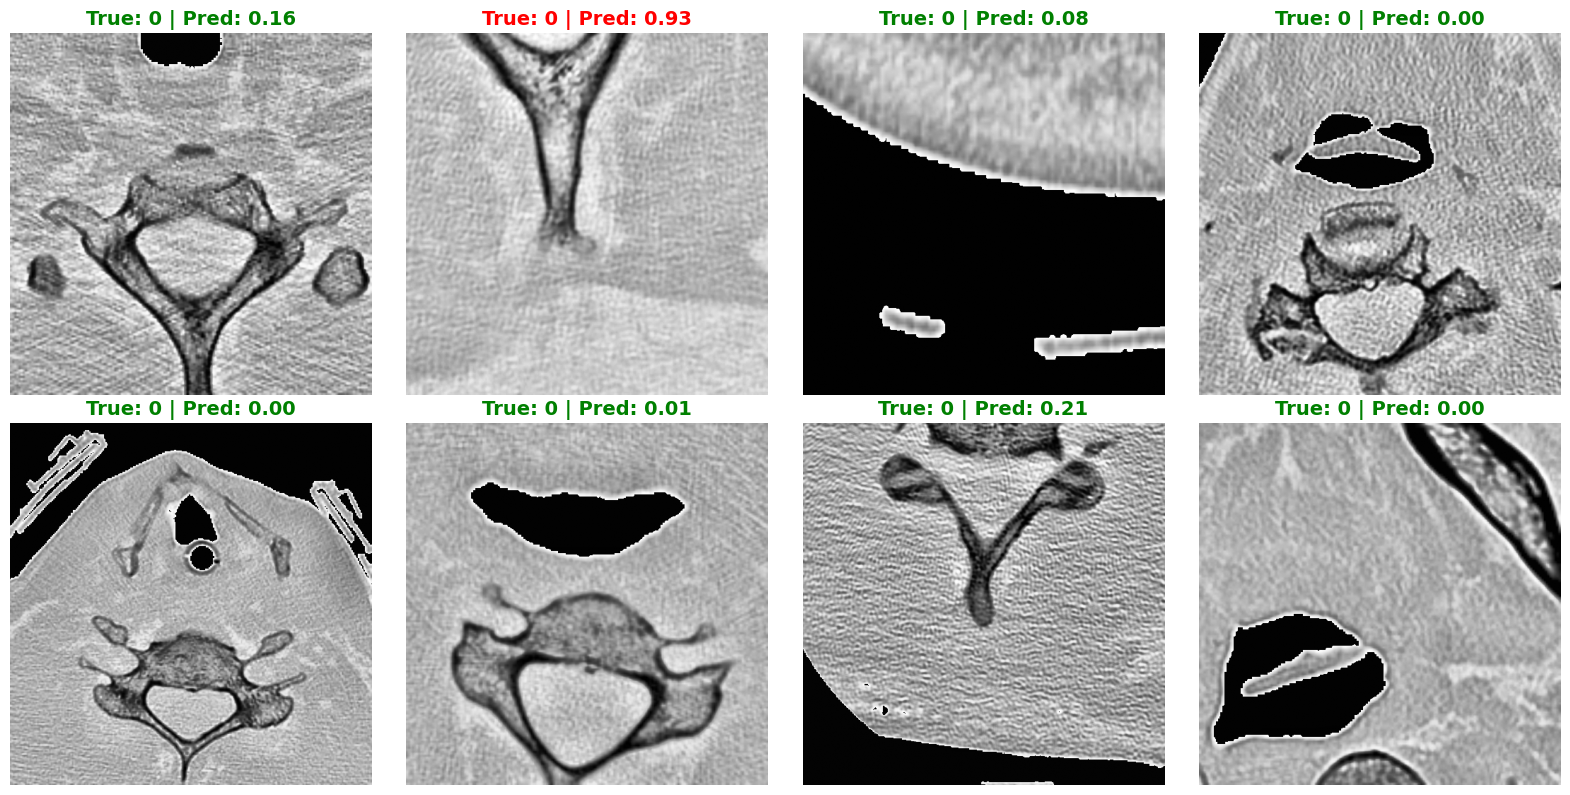

In [3]:
import os
import torch
import pandas as pd
import numpy as np
import cv2
import timm
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
import random

# --- [1. 설정] ---
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection',
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\old_train\det_train_manifest_2019_3ch.csv',
    'true_label_csv': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_cropped_full.csv',
    
    'model_name': 'tf_efficientnetv2_s.in21k_ft_in1k', 
    'img_size': 512,
    
    # 🎯 학습 완료된 우리 모델 가중치 경로
    'weights_path': './runs/rsna_clf_efficientnet_golden_235/best_efficientnet_golden_235.pth', 
    
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_samples': 8
}

val_transforms = A.Compose([
    A.Resize(CONFIG['img_size'], CONFIG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

class RSNATestDataset(Dataset):
    def __init__(self, df, base_dir, transforms=None):
        self.df = df
        self.base_dir = base_dir
        self.transforms = transforms
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        
    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, 'old_train', row['file_path'])
        try:
            with np.load(full_path) as loaded: img = loaded['data'].astype(np.float32) 
        except:
            img = np.zeros((3, 512, 512), dtype=np.float32)

        img_uint8 = (img * 255).astype(np.uint8)
        channels = [self.clahe.apply(img_uint8[i]) for i in range(3)]
        img_hwc = np.stack(channels, axis=-1) 
        
        if self.transforms: img_tensor = self.transforms(image=img_hwc)['image']
        else: img_tensor = torch.from_numpy(np.transpose(img_hwc, (2,0,1))).float() / 255.0

        label = float(row['fracture'])
        vis_img = channels[1] 
        return img_tensor, label, vis_img

def visualize_main_model():
    print("🛠️ 메인 모델(단일 출력) 데이터 준비 중...")
    df_3ch = pd.read_csv(CONFIG['manifest_path']) 
    df_true = pd.read_csv(CONFIG['true_label_csv'])
    df_3ch['StudyInstanceUID'] = df_3ch['StudyInstanceUID'].astype(str)
    df_true['StudyInstanceUID'] = df_true['StudyInstanceUID'].astype(str)
    
    df_merged = pd.merge(
        df_3ch[['StudyInstanceUID', 'original_slice_number', 'file_path']], 
        df_true[['StudyInstanceUID', 'original_slice_number', 'fracture']], 
        on=['StudyInstanceUID', 'original_slice_number'], how='inner'
    ).reset_index(drop=True)

    # 학습 때와 동일하게 분할하여 안 본 데이터(Val)만 추출!
    gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
    _, val_idx = next(gss.split(df_merged, groups=df_merged['StudyInstanceUID']))
    val_df = df_merged.iloc[val_idx].reset_index(drop=True)
    
    # 정답(골절)이 있는 사진 위주로 보려면 아래 주석 해제!
    # val_df = val_df[val_df['fracture'] == 1].reset_index(drop=True) 

    sample_df = val_df.sample(n=CONFIG['num_samples'], random_state=random.randint(0, 10000))
    test_loader = DataLoader(RSNATestDataset(sample_df, CONFIG['base_dir'], transforms=val_transforms), batch_size=CONFIG['num_samples'], shuffle=False)
    
    model = timm.create_model(CONFIG['model_name'], pretrained=False, in_chans=3, num_classes=1)
    model.load_state_dict(torch.load(CONFIG['weights_path'], map_location=CONFIG['device']))
    model.to(CONFIG['device']).eval()
    
    with torch.no_grad():
        for images, labels, vis_imgs in test_loader:
            probs = torch.sigmoid(model(images.to(CONFIG['device']))).cpu().numpy().flatten()
            labels = labels.numpy()
            break 
            
    plt.figure(figsize=(16, 8))
    for i in range(CONFIG['num_samples']):
        plt.subplot(2, 4, i+1)
        plt.imshow(vis_imgs[i], cmap='gray')
        plt.axis('off')
        
        true_lbl = int(labels[i])
        pred_prob = probs[i]
        pred_lbl = 1 if pred_prob >= 0.5 else 0
        color = 'green' if true_lbl == pred_lbl else 'red'
        
        plt.title(f"True: {true_lbl} | Pred: {pred_prob:.2f}", color=color, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    visualize_main_model()